# Technical Test Equancy Interview

In [88]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive 

from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
#models library are imported below in section 8

import re

In [41]:
drive.mount('/content/gdrive')

df=pd.read_csv('gdrive/My Drive/Equancy/data.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### little exploration of the dataset before answering the questions

In [42]:
df.shape

(9582, 6)

In [43]:
df.dtypes

Entreprise      object
Metier          object
Technologies    object
Diplome         object
Experience      object
Ville           object
dtype: object

we will need to clean the dataset and have usefull types if we want to continue further

In [44]:
print(f"Number of duplicated rows : {len(df) - len(df.drop_duplicates())}")

Number of duplicated rows : 32


we cannot iterpret this since the dataset has no column 'id'......

In [45]:
df_temp=df.drop_duplicates()
df_temp.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [46]:
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

In [47]:
df['Metier'].value_counts()/len(df)

Data scientist         0.403360
Data engineer          0.244938
Data architecte        0.221561
Lead data scientist    0.128157
Name: Metier, dtype: float64

### Handleling types, missing values for experiences...

In [48]:
df['Experience'] = df['Experience'].str.replace(',', '.', regex=True).astype(float)
df.dtypes

Entreprise       object
Metier           object
Technologies     object
Diplome          object
Experience      float64
Ville            object
dtype: object

# 1

In [49]:
df.shape

(9582, 6)

There are 9582 observations in this dataset.

In [50]:
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

There are some missing values in this dataset.

# 2

La question ne me dis pas si je dois prendre la moyenne et la médiane générale (tout métier confondu) ou si je dois prendre la médiane des data scientists seulement et la moyenne des data engineer seulement. 

In [51]:
meds=df.groupby('Metier')['Experience'].median()
med_scientist=meds.loc['Data scientist']

means=df.groupby('Metier')['Experience'].mean()
mean_engineers=means.loc['Data engineer']

med_gen=df['Experience'].median()
mean_gen=df['Experience'].mean()

print(f"med_scientist {med_scientist}")
print(f"mean_engineers {mean_engineers}")
print()
print(f"med_gen {med_gen}")
print(f"mean_gen {mean_gen}")

med_scientist 2.0
mean_engineers 2.984959174903309

med_gen 2.0
mean_gen 2.8141863406408096


In [52]:
#a. la valeur médiane pour les data scientists
#b. la valeur moyenne pour les data engineers
med_scientist=df['Experience'].median()
mean_engineers=df['Experience'].mean()


df['Experience'].mask((df['Metier'] == 'Data scientist') & (df['Experience'].isna()) ,med_scientist , inplace=True)
df['Experience'].mask((df['Metier'] == 'Data engineer') & (df['Experience'].isna()) ,mean_engineers , inplace=True)
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux



the values have been replaced correctly.

# 3

We can look at the average year of experience of each profile with a groupby().mean() directly on our concerned column.

In [53]:
df.groupby(['Metier']).mean()

,Experience
Metier,
Data architecte,3.000476
Data engineer,2.983504
Data scientist,2.241268
Lead data scientist,3.965261


# 4

I propose 3 simple representations to visualize the average number of years of experience for each trade. 

1) Simple histogram 

2) Boxplot to show the quartiles.

3) Violinplot to show the range of the data.

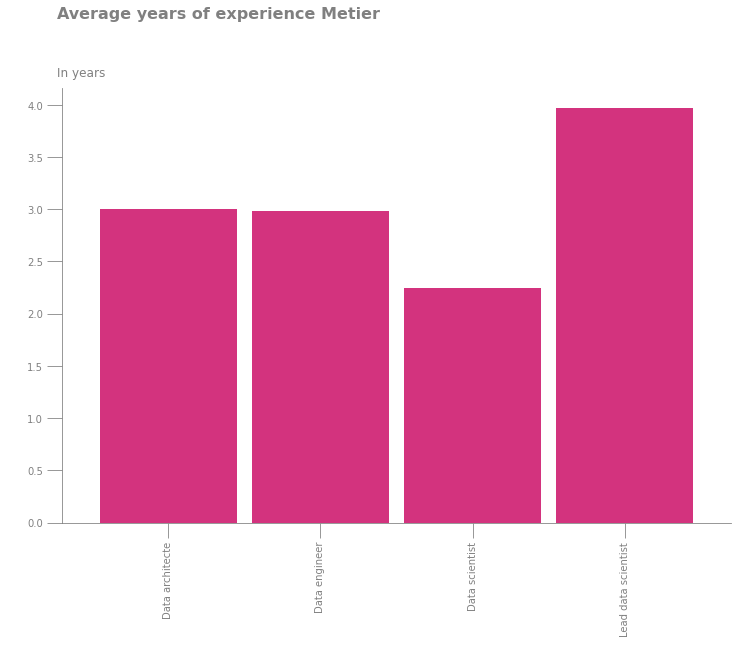

In [54]:
fig,ax = plt.subplots(figsize = (12,8))

ax.grid(ls="dotted", lw="0.5", color="grey", zorder=1)

hfont = {'fontname':'DejaVu Sans'}

fig.set_facecolor("#ffffff")
ax.patch.set_facecolor("#ffffff")

ax.tick_params(colors="grey", length=15)

ax.spines['bottom'].set_color("grey")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color("grey")


df.groupby('Metier').mean()["Experience"].plot(kind='bar', zorder=0,width = 0.9, color="#d3337e")

plt.xlabel("Metier", color="w", fontsize=15 , **hfont)
plt.ylabel("Moyenne expérience", color="w", fontsize=15 , **hfont)

fig.text(0.12,0.97, s="Average years of experience Metier \n", fontsize = 16, fontweight = "bold", color = "grey", **hfont)
fig.text(0.12,0.9, "In years", fontsize = 12, fontweight="light", color = "grey", **hfont)

plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



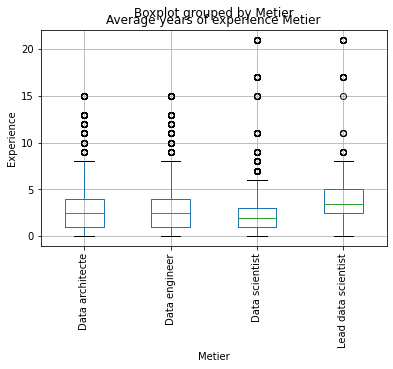

In [55]:
df.boxplot(column='Experience', by='Metier', rot=90)

plt.title("Average years of experience Metier")
plt.xlabel('Metier')
plt.ylabel('Experience')

plt.show()


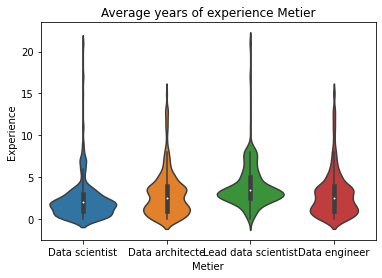

In [56]:
sns.violinplot(x='Metier', y='Experience', data=df)

plt.title("Average years of experience Metier")
plt.xlabel('Metier')
plt.ylabel('Experience')

plt.show()

# 5

As we want the continuous variable Experience in 4 different modalities the most sensible approach would be to look at the distribution (quartiles) of this variable to create balanced buckets.

Another approach would be a personalized approach of the problem, indeed we may want a rarer representation of the "expert" profile which could for example only concern the "outliers" with an experience higher than 10 years.

Without additional information, I stick to the first method.

In [57]:
df['Experience'].describe()

count    9540.000000
mean        2.811455
std         2.709288
min         0.000000
25%         1.000000
50%         2.000000
75%         3.500000
max        21.000000
Name: Experience, dtype: float64

The goal will be to set thresholds for each bucket using its quartiles.

In [58]:
def createbucket(val):
    bucket=""
    if val <= _1st_quart_threshold:
        bucket="debutant"
    if (val > _1st_quart_threshold) & (val <= _2nd_quart_threshold ):
        bucket="confirmé"
    if (val > _2nd_quart_threshold) & (val <= _3rd_quart_threshold ):
        bucket="avancé"
    if val > _3rd_quart_threshold:
        bucket="expert"
    return bucket

In [59]:
_1st_quart_threshold = df['Experience'].quantile(0.25)
_2nd_quart_threshold = df['Experience'].quantile(0.50)
_3rd_quart_threshold = df['Experience'].quantile(0.75)

df['Exp_label'] = df['Experience']
df["Exp_label"] = df["Exp_label"].apply(lambda x : createbucket(x))

df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,avancé
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,avancé
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,confirmé
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,confirmé
...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.5,Lyon,confirmé
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.0,Toulouse,expert
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.0,Paris,debutant
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.0,Rennes,expert


# 6

To do this question, we need to get each technology from each list in the "technologies" column. This will also be useful for the next step.

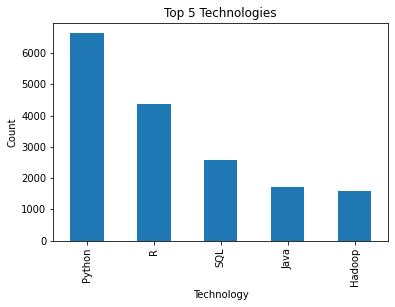

In [60]:
df_split=df['Technologies'].str.split('/', expand=True).stack().reset_index(level=1, drop=True)
df_split.name='technology'

tech_count=df_split.value_counts()

top_5=tech_count.head(5)

top_5.plot.bar()
plt.title('Top 5 Technologies')
plt.xlabel('Technology')
plt.ylabel('Count')

plt.show()

Les 5 technologies les plus utilisées sont donc les suivantes : Python, R, SQL, Java et Hadoop. Elles font parties des technologies populaires dans le monde du Big Data.

# 7

I decide to take everything as an input variable to perform a Kmeans clustering. 

1) approach with an arbitrary number of clusters: I set it to 4 because my hypothesis is that 4 clusters should naturally emerge according to the 4 different job profiles that we have in our data.

2) approach with the "elbow" method to determine the ideal number of clusters according to the inertia metric.

In [61]:
df_split_tech=df['Technologies'].str.get_dummies(sep='/')
df_split=df[['Metier', 'Diplome', 'Ville', 'Exp_label','Entreprise']]
data=pd.get_dummies(df_split, columns=['Metier', 'Diplome', 'Ville', 'Exp_label','Entreprise'])
df_clust=pd.concat([data, df_split_tech], axis=1)
df_clust

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Ville_Bordeaux,Ville_Grenoble,...,Tensorflow,Teradata,VBA,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn
0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9578,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9579,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
9580,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


As 4 different jobs we will initialize the cluster search to 4.

In [62]:
kmeans=KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_clust)
clusters=kmeans.predict(df_clust)
clusters

array([3, 1, 2, ..., 3, 3, 3], dtype=int32)

In [63]:
len(clusters)

9582

Try to find optimal K

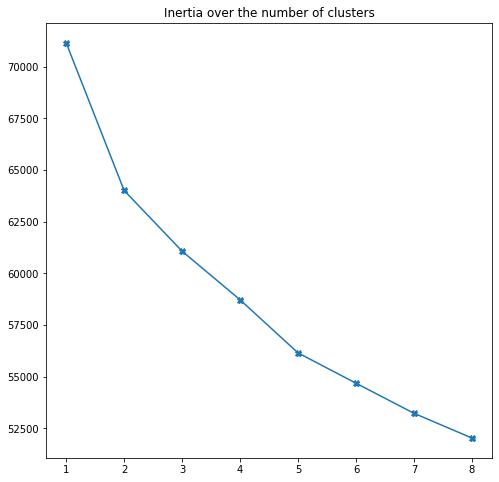

In [64]:
inertias=[]
K=range(1,9) #8 is the by default n_clusters for Kmeans
for k in K:
    kmeanModel= KMeans(n_clusters=k)
    kmeanModel.fit(df_clust)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(8,8))
plt.plot(K, inertias, 'X-')
plt.title('Inertia over the number of clusters')
plt.show()

The bend seems to be located for n_clusters=2

In [65]:
#n_clusters=2
kmeans= KMeans(n_clusters=2, random_state=0)
kmeans.fit(df_clust)
clusters=kmeans.predict(df_clust)


df['cluster']=clusters


pca = PCA(n_components=2)
components = pca.fit_transform(df_clust)

fig = px.scatter(components, x=0, y=1, color =df["cluster"], color_discrete_sequence=[
                 "#416221", "#95b23b", "#836a12", "#bbbdbb", "#3f4239", "#cddd55", "#6e962a", "#e6a528"], title = "2D PCA representing the clusters")
fig.show()

In [66]:
#peut pas faire cette viz avec les NaN
df2=df.dropna()
df_split_tech=df2['Technologies'].str.get_dummies(sep='/')
df_split=df2[['Metier', 'Diplome', 'Ville', 'Exp_label','Entreprise']]
data=pd.get_dummies(df_split, columns=['Metier', 'Diplome', 'Ville', 'Exp_label','Entreprise'])
df_clust2=pd.concat([data, df_split_tech], axis=1)
kmeans2= KMeans(n_clusters=2, random_state=0)
kmeans2.fit(df_clust2)
clusters2 = kmeans2.predict(df_clust2)

df2['cluster'] = clusters2

pca2 = PCA(n_components=2)
components2 = pca2.fit_transform(df_clust2)

fig = px.scatter(components2, x=0, y=1, color =df2["Metier"], color_discrete_sequence=[
                 "#416221", "#95b23b", "#836a12", "#bbbdbb", "#3f4239", "#cddd55", "#6e962a", "#e6a528"], title = "2D PCA representing the Metiers")
fig.show()

<ipython-input-66-7c62836bb289>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As we can see in the 2D representation, the data scientist and lead data scientist are very close to be identified separately as data engineer and data architect. The choice to create 2 clusters was therefore justified from a business point of view.

In [67]:
fig = px.scatter(components, x=0, y=1, color =df["Diplome"], color_discrete_sequence=[
                 "#416221", "#95b23b", "#836a12", "#bbbdbb", "#3f4239", "#cddd55", "#6e962a", "#e6a528"], title = "2D PCA representing the Diplomes")
fig.show()

What are the technical profile in the 2 clusters? I will do this with the code from previous question.

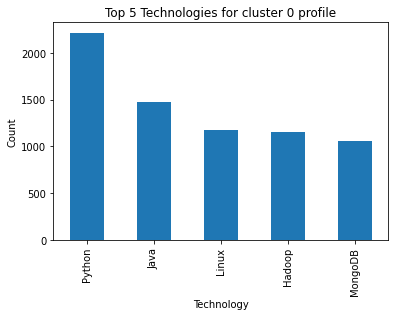

In [68]:
df3=df2[df2['cluster']==0]
df_split=df3['Technologies'].str.split('/', expand=True).stack().reset_index(level=1, drop=True)
df_split.name='technology'

tech_count=df_split.value_counts()

top_5=tech_count.head(5)

top_5.plot.bar()
plt.title('Top 5 Technologies for cluster 0 profile')
plt.xlabel('Technology')
plt.ylabel('Count')

plt.show()

The main technologies from this clusters are oriented as database and architecture management as we can see Java for application developpment or MongoDB for NoSQL databases. We could deduce that this cluster should contains profile that have metier such as data engineer or data architect.

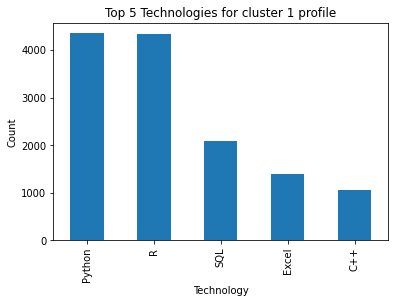

In [69]:
df3=df2[df2['cluster']==1]
df_split=df3['Technologies'].str.split('/', expand=True).stack().reset_index(level=1, drop=True)
df_split.name='technology'

tech_count=df_split.value_counts()

top_5=tech_count.head(5)

top_5.plot.bar()
plt.title('Top 5 Technologies for cluster 1 profile')
plt.xlabel('Technology')
plt.ylabel('Count')

plt.show()

The main technologies from this clusters are oriented towards programming and data analysis tools as we can see Python/R or Excel. We could deduce that this cluster should contains profile that have metier such as data scientists.

# 8

1) Approach starting from a dataset similar to the previous question. As we have only categorical variables we have to choose an encoding strategy. This first approach will use a one hot encoding strategy only.

This will not be my final approach, rather a first test approach, so I will only test accuracy on this approach.

I will reuse a dataset similar to the one used in the unsupervised part at first. The variables will be only dummies (one hot encoding).

In [70]:
df_split_tech=df['Technologies'].str.get_dummies(sep='/')
df_split=df[['Diplome', 'Ville', 'Exp_label','Entreprise']]
data=pd.get_dummies(df_split, columns=['Diplome', 'Ville', 'Exp_label','Entreprise'])
df_Supervised=pd.concat([data, df_split_tech], axis=1)
df_Supervised['Metier']=df['Metier']
df_Supervised

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Ville_Bordeaux,Ville_Grenoble,Ville_Lille,Ville_Lyon,Ville_Marseille,Ville_Montpellier,...,Teradata,VBA,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn,Metier
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Data architecte
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,Lead data scientist
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Data scientist
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
9578,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,Data scientist
9579,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,Data scientist
9580,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Data scientist


In [71]:
test= df_Supervised[df_Supervised['Metier'].isna()]
test

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Ville_Bordeaux,Ville_Grenoble,Ville_Lille,Ville_Lyon,Ville_Marseille,Ville_Montpellier,...,Teradata,VBA,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn,Metier
346,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2058,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,NaN
2670,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2899,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
3346,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4248,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4290,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
4292,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
5425,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5593,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,NaN


In [72]:
df_Supervised=df_Supervised.dropna()
df_Supervised

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Ville_Bordeaux,Ville_Grenoble,Ville_Lille,Ville_Lyon,Ville_Marseille,Ville_Montpellier,...,Teradata,VBA,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn,Metier
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Data architecte
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,Lead data scientist
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Data scientist
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Data scientist
9578,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,Data scientist
9579,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,Data scientist
9580,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Data scientist


In [73]:
df_Supervised=df_Supervised.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #problème d'inputs avec la colonne C++
df_Supervised=df_Supervised.drop(df_Supervised.columns[1410], axis=1)

X = df_Supervised.drop(['Metier'],axis=1)   # independant features
y = df_Supervised['Metier']					# dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=78)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7172, 1463)
(2391, 1463)
(7172,)
(2391,)


In [74]:
for col in df_Supervised.columns:
    print(col)

Diplome_Bachelor
Diplome_Master
Diplome_Nodiploma
Diplome_Phd
Ville_Bordeaux
Ville_Grenoble
Ville_Lille
Ville_Lyon
Ville_Marseille
Ville_Montpellier
Ville_Nantes
Ville_Nice
Ville_Paris
Ville_Rennes
Ville_Rouen
Ville_Strasbourg
Ville_Toulon
Ville_Toulouse
Exp_label_
Exp_label_avanc
Exp_label_confirm
Exp_label_debutant
Exp_label_expert
Entreprise_10xGenomics
Entreprise_1871
Entreprise_23andMe
Entreprise_2MResearchServices
Entreprise_3QDigital
Entreprise_605
Entreprise_7ParkData
Entreprise_8451
Entreprise_AENetworks
Entreprise_ALineStaffing
Entreprise_AARP
Entreprise_ABSciexPte
Entreprise_ACTCommodities
Entreprise_ADP
Entreprise_AECOM
Entreprise_AFLCIO
Entreprise_AHAAmericanHospitalAssociation
Entreprise_AIIoTBlockchainNewCo
Entreprise_AIG
Entreprise_AIRWorldwide
Entreprise_AKCEATherapeutics
Entreprise_ALSTDI
Entreprise_AMERICANCANCERSOCIETY
Entreprise_AMPAgency
Entreprise_ANALYTICA
Entreprise_APStaffing
Entreprise_APTIM
Entreprise_ARYZTACareers
Entreprise_ARiA
Entreprise_ASRCFederalHoldi

I choose to test these algorithms and then I will try to optimize the one that would give the best results by time constraints.

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [76]:
def fit_and_get_performance(algo, X_train, y_train, X_test, y_test):
    
    model = algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    return [accuracy]

In [77]:
print("start")

seed_num = 10

knn_model=KNeighborsClassifier(n_jobs=-1)
mlp_model=MLPClassifier(random_state=seed_num,max_iter=20)
lgb_model=lgb.LGBMClassifier(n_estimators=20)

column_names = ['Models', 'Accuracy']
Models_Scores = pd.DataFrame(columns = column_names)

Models = [knn_model,  mlp_model, lgb_model]
Models_Column = ['k-Nearest Neighbors',
              'multi layer perceptron',
                 'Light GBM']
             


i=0
for model in Models:
    print(str(model)+' starting')
    scores = fit_and_get_performance(model, X_train, y_train, X_test, y_test)
    row = [Models_Column[i]] + scores
    Models_Scores.loc[i+1] = row
    i+=1
    
Models_Scores.sort_values(by='Accuracy', ascending=False)

start
KNeighborsClassifier(n_jobs=-1) starting
MLPClassifier(max_iter=20, random_state=10) starting


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



LGBMClassifier(n_estimators=20) starting


,Models,Accuracy
3,Light GBM,0.869929
2,multi layer perceptron,0.855709
1,k-Nearest Neighbors,0.839816


### Let's try another type of encoding (Count encoding or Target encoding)

2) In this 2nd approach I adopt a different strategy, the one hot encoding is not a very advised way when the cardiality of a categorical variable is important. So I will keep the one-hot encoding on the variables technologies, diploma and exp_label and perform a count encoding on the variables like company. I chose the count encoding method because I have already done some work using target encoding and it seems that these 2 methods are quite similar. I didn't use target encoding because I had problems of interpretations with the multi class target variable.

In [78]:
df_split_tech = df['Technologies'].str.get_dummies(sep='/')
df_split=df[['Diplome', 'Exp_label']]
data = pd.get_dummies(df_split, columns=['Diplome', 'Exp_label'])
df_Supervised = pd.concat([data, df_split_tech], axis=1)
df_Supervised['Ville']=df['Ville']
df_Supervised['Entreprise']=df['Entreprise']
df_Supervised['Metier']=df['Metier']

def convertclass(metier):
    classe=5
    if metier == "Data scientist":
        classe=0
    if metier == "Lead data scientist":
        classe=1
    if metier == "Data engineer":
        classe=2
    if metier == "Data architecte":
        classe=3
    return classe

df_Supervised['Metier']=df['Metier'].apply(lambda x : convertclass(x))

df_Supervised

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_,Exp_label_avancé,Exp_label_confirmé,Exp_label_debutant,Exp_label_expert,AI,...,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn,Ville,Entreprise,Metier
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,Paris,Sanofi,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,Marseille,Massachusetts General Hospital(MGH),3
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,Nantes,Delve,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Marseille,Ann & Robert H. Lurie Children’s Hospital of C...,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,Bordeaux,Arm,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Lyon,Massachusetts General Hospital(MGH),0
9578,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,Toulouse,Charles River Analytics,0
9579,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,Paris,Ball Aerospace,0
9580,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,Rennes,Takeda Pharmaceutical,0


In [79]:
test=df_Supervised[df_Supervised['Metier']==5]
df_Supervised=df_Supervised[df_Supervised['Metier']<5]
test

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_,Exp_label_avancé,Exp_label_confirmé,Exp_label_debutant,Exp_label_expert,AI,...,Vertica,Windows,Yarn,anglais,machine learning,numpy,scikit-learn,Ville,Entreprise,Metier
346,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,Paris,Jacobs,5
2058,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,Lyon,Ball Aerospace,5
2670,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Toulouse,"eHire, LLC",5
2899,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,Grenoble,Norfolk Southern Corp,5
3346,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,Rennes,J.E. Ranta Associates,5
4248,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Lyon,KPMG,5
4290,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Toulouse,"Pandora Media, Inc.",5
4292,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,Bordeaux,Partners HealthCare(PHS),5
5425,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,Lyon,Ashton Lane Group,5
5593,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,Lyon,Lighthouse Lab Services,5


encode city and company according to their total number of occurrences.

In [80]:
# Counts encoding
icols =  [
            ['Ville'],
            ['Entreprise']            
            ]

for col in icols:
    print('Encoding', col)
    counts=df_Supervised[col].value_counts().to_dict()
    col_name= '_'+'_'.join(col)+'_'


    df_Supervised['enc'+col_name+'count']=df_Supervised[col].replace(counts)
    test['enc'+col_name+'count']=test[col].replace(counts)

    #col_name = '_'+'_'.join(col)+'_'
    #df_Supervised['enc'+col_name+'mean']=df_Supervised.groupby(col)['Metier'].transform('mean').astype(np.float16) #target encoding

df_Supervised.head(25)

Encoding ['Ville']
Encoding ['Entreprise']


<ipython-input-80-7d7ed08b84fe>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-80-7d7ed08b84fe>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_,Exp_label_avancé,Exp_label_confirmé,Exp_label_debutant,Exp_label_expert,AI,...,Yarn,anglais,machine learning,numpy,scikit-learn,Ville,Entreprise,Metier,enc_Ville_count,enc_Entreprise_count
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,Paris,Sanofi,0,2011,28.0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,Marseille,Massachusetts General Hospital(MGH),3,1545,83.0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,Nantes,Delve,1,365,8.0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,Marseille,Ann & Robert H. Lurie Children’s Hospital of C...,0,1545,21.0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,1,Bordeaux,Arm,0,690,16.0
5,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Lille,S&P Global Ratings,1,771,7.0
6,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,Lille,NVIDIA,0,771,12.0
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Toulouse,Cedars-Sinai Medical Center,0,869,12.0
8,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Paris,Fibroblast,3,2011,3.0
9,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,Toulouse,General Motors,2,869,4.0


In [81]:
#All the inputs variable and target 'Metier'
for col in df_Supervised.columns:
    print(col)

Diplome_Bachelor
Diplome_Master
Diplome_No diploma
Diplome_Phd
Exp_label_
Exp_label_avancé
Exp_label_confirmé
Exp_label_debutant
Exp_label_expert
AI
AWS
Anglais
Big data
C
C++
Cassandra
Deep learning
Docker
Elasticsearch
Excel
GNU
HBASE
HDFS
Hadoop
Hadoop(HDFS)
Hive
Java
Kafka
Kibana
Linux
Machine learning
Map-Reduce
MariaDB
Matlab
Matplotlib
Microsoft Azure
MongoDB
MySQL
NoSQ
NoSQL
ORACLE
PIG
Perl
PostgreSQL
PySpark
Pycharm
Pyspark
Python
R
Redshift
Ruby
SAS
SPSS
SQL
Scala
Scikit-learn
Scoring
Spark
Tableau
Tensorflow
Teradata
VBA
Vertica
Windows
Yarn
anglais
machine learning
numpy
scikit-learn
Ville
Entreprise
Metier
enc_Ville_count
enc_Entreprise_count


In [82]:
df_Supervised=df_Supervised.dropna()

X = df_Supervised.drop(['Metier','Entreprise','Ville','C++'],axis=1)   # independant features
y = df_Supervised['Metier']					# dependant variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=78) #shuffle split because of time constraints
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7159, 70)
(2387, 70)
(7159,)
(2387,)


je vérifie si mes classes sont équilibrées ou non.

In [83]:
# distribution de la target 
print(y_train.value_counts())
print(y_test.value_counts())

0    2916
2    1758
3    1552
1     933
Name: Metier, dtype: int64
0    944
2    585
3    567
1    291
Name: Metier, dtype: int64


In [84]:
# pourcentage 
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.407319
2    0.245565
3    0.216790
1    0.130325
Name: Metier, dtype: float64
0    0.395475
2    0.245078
3    0.237537
1    0.121910
Name: Metier, dtype: float64


Problem is that the data is not balanced, if we use only one metric like accuracy it will bias our model. We will then look at metrics like the f1 score or the AUC.

In [85]:
print("start")

seed_num = 10

knn_model=KNeighborsClassifier(n_jobs=-1)
mlp_model=MLPClassifier(random_state=seed_num,max_iter=20)
lgb_model=lgb.LGBMClassifier(n_estimators=20)
rf_model=RandomForestClassifier(random_state=seed_num,n_jobs=-1)
xgb_model=xgb.XGBClassifier(n_estimators=20)

column_names = ['Models', 'Accuracy']
Models_Scores = pd.DataFrame(columns = column_names)

Models = [knn_model,  mlp_model, lgb_model,rf_model,xgb_model]
Models_Column = ['k-Nearest Neighbors',
              'multi layer perceptron',
                 'Light GBM','Random Forest','XGBOOST']
             


i=0
for model in Models:
    print(str(model)+' starting')
    scores = fit_and_get_performance(model, X_train, y_train, X_test, y_test)
    row = [Models_Column[i]] + scores
    Models_Scores.loc[i+1] = row
    i+=1
    
Models_Scores.sort_values(by='Accuracy', ascending=False)

start
KNeighborsClassifier(n_jobs=-1) starting
MLPClassifier(max_iter=20, random_state=10) starting


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



LGBMClassifier(n_estimators=20) starting
RandomForestClassifier(n_jobs=-1, random_state=10) starting
XGBClassifier(n_estimators=20) starting


,Models,Accuracy
3,Light GBM,0.901969
4,Random Forest,0.886468
2,multi layer perceptron,0.808127
5,XGBOOST,0.763720
1,k-Nearest Neighbors,0.622958


I choose to look in more detail at the metrics of the 3 best algos on the accuracy test. Maybe XGBoost would have been a solution to explore in more detail since this algorithm is supposed to react better than LGBM on smaller datasets.

In [86]:
print('LGBM')
print(classification_report(y_test, lgb_model.predict(X_test)))
print('MLP')
print(classification_report(y_test, mlp_model.predict(X_test)))
print('RANDOM FOREST')
print(classification_report(y_test, rf_model.predict(X_test)))

LGBM
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       944
           1       0.68      0.49      0.57       291
           2       1.00      1.00      1.00       585
           3       0.99      0.98      0.98       567

    accuracy                           0.90      2387
   macro avg       0.88      0.85      0.86      2387
weighted avg       0.90      0.90      0.90      2387

MLP
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       944
           1       0.82      0.12      0.21       291
           2       0.97      0.76      0.85       585
           3       0.84      0.90      0.87       567

    accuracy                           0.81      2387
   macro avg       0.84      0.69      0.70      2387
weighted avg       0.83      0.81      0.78      2387

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       94

The Lgbm model appears to have the best results on the hybrid metrics for unbalanced classes. 

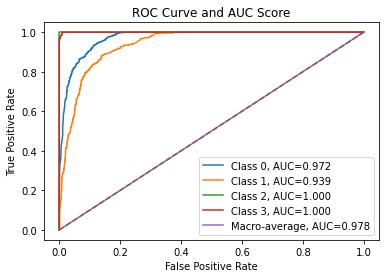

In [89]:
y_pred_prob = lgb_model.predict_proba(X_test)

classes = lgb_model.classes_

aucs = []

# for each class, calculate the ROC curve and AUC score
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test==classes[i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test==classes[i], y_pred_prob[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label=f'Class {i}, AUC={auc:.3f}')


macro_auc = np.mean(aucs)
plt.plot([0, 1], [0, 1], label=f'Macro-average, AUC={macro_auc:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC Score')
plt.show()

It is difficult to interpret these curves because the areas under the curves seem to be close to 1. However, we can see that it is always class 1, i.e. Lead data scientist, where the model has the most difficulty.



## searching for hyperparameters for LGB model


In [90]:
param_grid =  {
                'boosting_type': ['gbdt'],
                'max_depth': [4,5,6],
                 'num_leaves':[2**4-1,2**5-1,2**6-1],
               'n_estimators':[50,100,150],
               'objective':['multiclass'],
               'subsample':[0, 0.5,1],
               'subsample_freq':[0, 0.5,1]
                              
              }

grid_lgb = RandomizedSearchCV(lgb_model, param_distributions = param_grid, n_iter=10, cv = 3, verbose = True, n_jobs = -1)
opti_grid_lgb = grid_lgb.fit(X_train, y_train)
opti_lgb_model = opti_grid_lgb.best_estimator_
opti_grid_lgb.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 997, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 791, 

{'subsample_freq': 0,
 'subsample': 0.5,
 'objective': 'multiclass',
 'num_leaves': 31,
 'n_estimators': 150,
 'max_depth': 5,
 'boosting_type': 'gbdt'}

In [91]:
print('LGBM opti')
print(classification_report(y_test, opti_lgb_model.predict(X_test)))

LGBM opti
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       944
           1       0.66      0.59      0.62       291
           2       1.00      1.00      1.00       585
           3       0.98      0.99      0.99       567

    accuracy                           0.91      2387
   macro avg       0.88      0.87      0.88      2387
weighted avg       0.91      0.91      0.91      2387



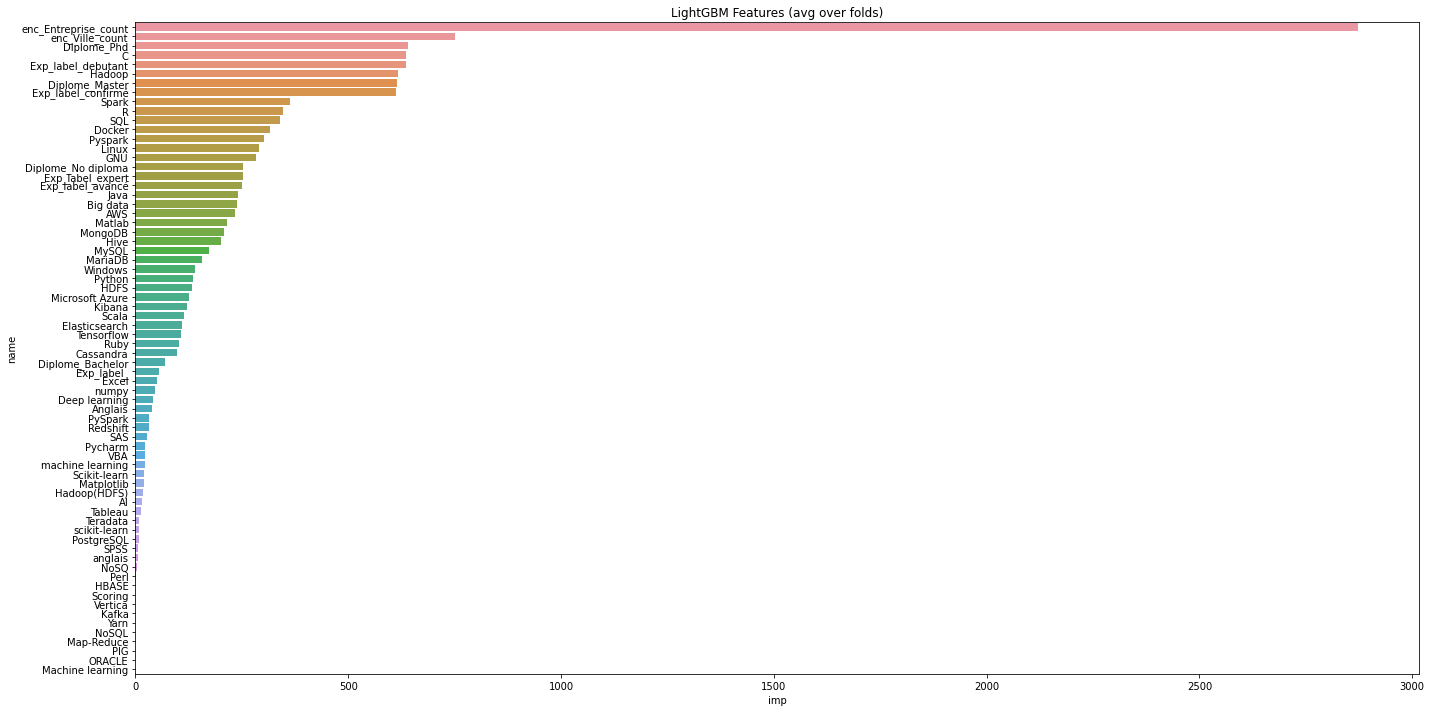

In [92]:
featimp=pd.DataFrame({'name':X_train.columns,
                     'imp':opti_lgb_model.feature_importances_}).sort_values('imp',ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x="imp", y="name", data=featimp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

As we can see, the company seems to be one of the most informative criteria for the algorithm although nowadays companies are looking to recruit different profiles for their data units.

Predictions of missing Metier

In [93]:
test = test.drop(['Metier','Entreprise','Ville','C++'],axis=1)   # independant features

preds=opti_lgb_model.predict(test)
preds

array([2, 1, 0, 0, 3, 0, 0, 1, 2, 0, 3, 2, 3, 0, 2, 0, 3, 0, 0])

In [94]:
res = df[df['Metier'].isna()]
res['pred_Metier']=preds

def convertPreds(res):
    if res == 0:
        classe="Data scientist"
    if res == 1:
        classe="Lead data scientist"
    if res == 2:
        classe="Data engineer"
    if res == 3:
        classe="Data architecte"
    return classe

res['pred_Metier']=res['pred_Metier'].apply(lambda x : convertPreds(x))

res

<ipython-input-94-694ed45815df>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-94-694ed45815df>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,cluster,pred_Metier
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,avancé,1,Data engineer
2058,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,Lyon,expert,0,Lead data scientist
2670,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,confirmé,0,Data scientist
2899,Norfolk Southern Corp,NaN,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,debutant,0,Data scientist
3346,J.E. Ranta Associates,NaN,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,expert,1,Data architecte
4248,KPMG,NaN,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,confirmé,0,Data scientist
4290,"Pandora Media, Inc.",NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,confirmé,0,Data scientist
4292,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,expert,0,Lead data scientist
5425,Ashton Lane Group,NaN,Python/Pyspark/Spark,No diploma,5.0,Lyon,expert,1,Data engineer
5593,Lighthouse Lab Services,NaN,Python/R/machine learning/Excel/VBA/C++,Master,3.0,Lyon,avancé,0,Data scientist


Here are my final predictions. We have a good visual since there are only 17 values. This seems to be quite consistent with the class distribution (unbalanced) and with the clusters created in question 7. We can see that the predictions on Lead Data scientists were made on the profiles with the most experience.